# Diabetes Prediction using SVM linear classifier and web app

## Importing necessary libraries and getting familiar with our data

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model 
from sklearn.metrics import accuracy_score,precision_score, recall_score,f1_score,confusion_matrix

In [2]:
diabetes=pd.read_csv("diabetes.csv")

In [3]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(4), int64(5)
memory usage: 54.1 KB


In [4]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.677083,72.389323,29.089844,141.753906,32.434635,0.471876,33.240885,0.348958
std,3.369578,30.464161,12.106039,8.890820,89.100847,6.880498,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,102.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,28.000000,102.500000,32.050000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,169.500000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72.0,35,169.5,33.6,0.627,50,1
1,1,85,66.0,29,102.5,26.6,0.351,31,0
2,8,183,64.0,32,169.5,23.3,0.672,32,1
3,1,89,66.0,23,94.0,28.1,0.167,21,0
4,0,137,40.0,35,168.0,43.1,2.288,33,1


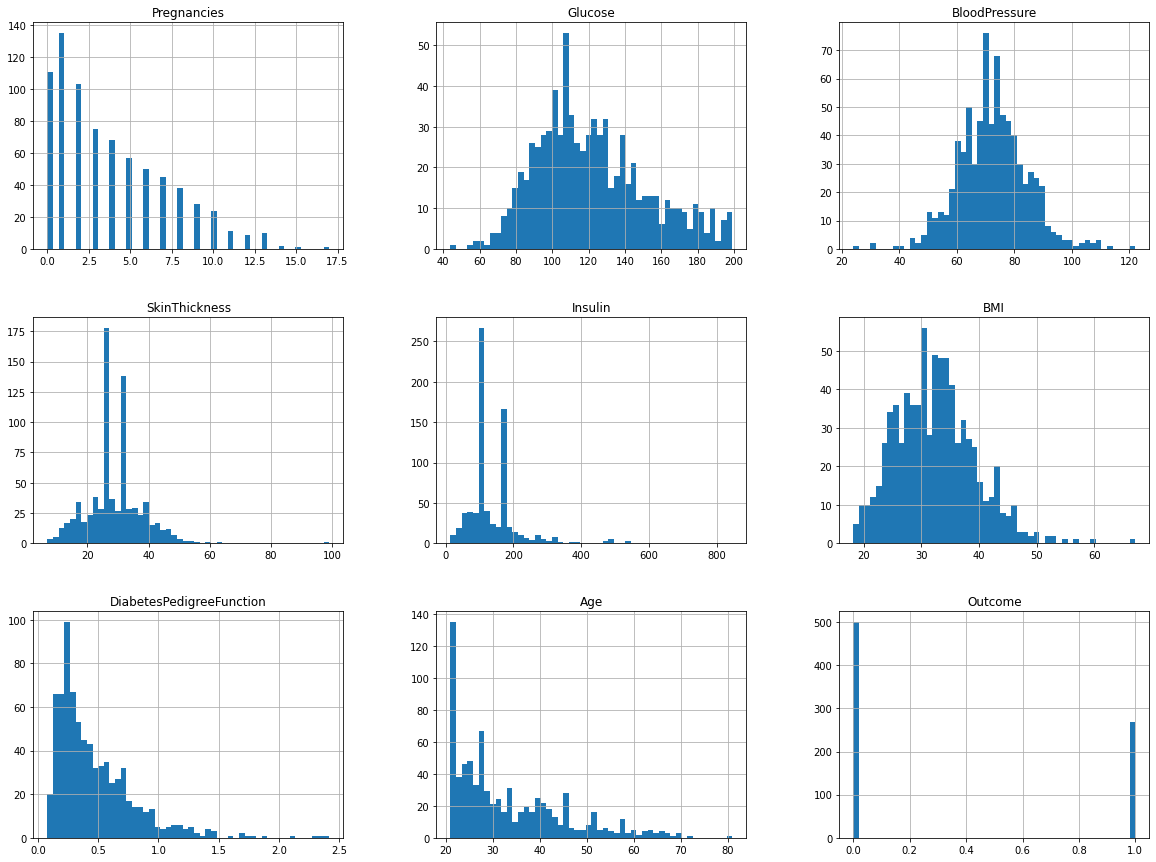

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
diabetes.hist(bins=50,figsize=(20,15))#bins is used for the width of histogram line
plt.show()

## Feature Engineering
In this part we will see the relation between different columns and our main outcome column.

Few columns like Pregnancies and Skin Thickness in medical terminology have no relation with a person is suffering from diabetes are not so we will be dropping these columns.

In [7]:
diabetes.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.130155,0.209151,0.089028,0.058767,0.023890,-0.033523,0.544341,0.221898
Glucose,0.130155,1.000000,0.225141,0.229289,0.490015,0.236171,0.138353,0.268910,0.495990
BloodPressure,0.209151,0.225141,1.000000,0.199349,0.070128,0.286399,-0.001443,0.325135,0.174469
SkinThickness,0.089028,0.229289,0.199349,1.000000,0.200129,0.566086,0.106280,0.129537,0.295138
Insulin,0.058767,0.490015,0.070128,0.200129,1.000000,0.238443,0.146878,0.123629,0.377081
BMI,0.023890,0.236171,0.286399,0.566086,0.238443,1.000000,0.152771,0.027849,0.315577
DiabetesPedigreeFunction,-0.033523,0.138353,-0.001443,0.106280,0.146878,0.152771,1.000000,0.033561,0.173844
Age,0.544341,0.268910,0.325135,0.129537,0.123629,0.027849,0.033561,1.000000,0.238356
Outcome,0.221898,0.495990,0.174469,0.295138,0.377081,0.315577,0.173844,0.238356,1.000000


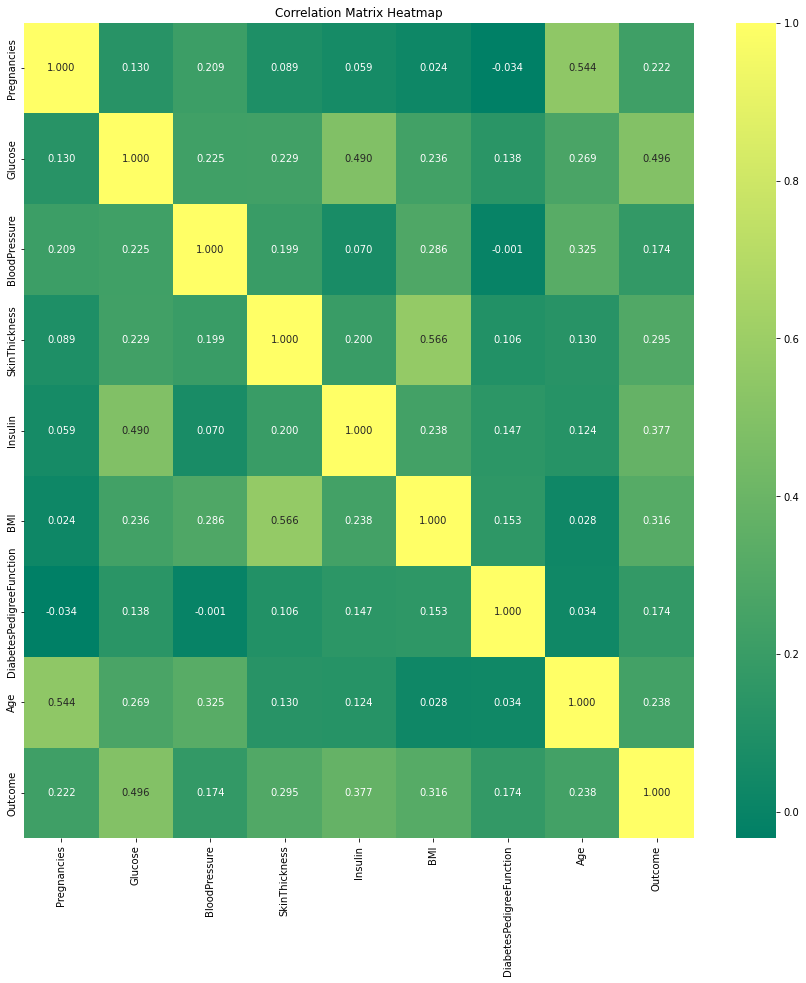

In [8]:
plt.figure(figsize=(15, 15))

correlation = diabetes.corr()
sns.heatmap(correlation, annot=True, fmt="0.3f", cmap="summer")
plt.title("Correlation Matrix Heatmap")
plt.show()

In [9]:
diabetes=diabetes.drop('Pregnancies',axis=1)
diabetes=diabetes.drop('SkinThickness',axis=1)

## Data Cleaning and managing the outliers

In [10]:
print(diabetes[diabetes.BloodPressure<40].shape[0])
print(diabetes[diabetes.Insulin<25].shape[0])

4
8


As we can see from above function a few patients have blood pressure less than 40 which is not possible in medical terminology as this suggest that the person is in coma. So well be remonig the rows with blood pressure lower than 40. Same is the case with Insulin.

In [11]:
diabetes=diabetes[diabetes.BloodPressure>40]
diabetes=diabetes[diabetes.Insulin>25]

In [12]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 755 entries, 0 to 767
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Glucose                   755 non-null    int64  
 1   BloodPressure             755 non-null    float64
 2   Insulin                   755 non-null    float64
 3   BMI                       755 non-null    float64
 4   DiabetesPedigreeFunction  755 non-null    float64
 5   Age                       755 non-null    int64  
 6   Outcome                   755 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 47.2 KB


In [13]:
corr_mat=diabetes.corr()
corr_mat.Outcome.sort_values(ascending=True)

DiabetesPedigreeFunction    0.159757
BloodPressure               0.180105
Age                         0.237790
BMI                         0.306476
Insulin                     0.375708
Glucose                     0.493894
Outcome                     1.000000
Name: Outcome, dtype: float64

# Normalizing the data

In [14]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
names = diabetes.columns
d = scaler.fit_transform(diabetes)
scaled_diabetes = pd.DataFrame(d, columns=names)

In [15]:
scaled_diabetes.head()

,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.670968,0.358974,0.171971,0.314928,0.243892,0.483333,1.0
1,0.264516,0.282051,0.089963,0.171779,0.121279,0.166667,0.0
2,0.896774,0.256410,0.171971,0.104294,0.263883,0.183333,1.0
3,0.290323,0.282051,0.079559,0.202454,0.039538,0.000000,0.0
4,0.464516,0.384615,0.089963,0.151329,0.054642,0.150000,0.0


## Splitting the data

In [16]:
def split_train_test(data,test_ratio):
    shuffled_indices=np.random.permutation(len(data))#randomly permute a sequence or return a permuted range
    test_set_size=int(len(data)*test_ratio)
    test_indices=shuffled_indices[:test_set_size]
    train_indices=shuffled_indices[test_set_size:]
    return data.iloc[train_indices],data.iloc[test_indices]

In [17]:
diabetes_train_set,diabetes_test_set=split_train_test(scaled_diabetes,0.2)

In [18]:
len(diabetes_train_set)

604

In [19]:
len(diabetes_test_set)

151

## Model testing and deployment

In [20]:
X_train=diabetes_train_set.drop("Outcome",axis=1)
Y_train=diabetes_train_set.Outcome.copy()
X_test=diabetes_test_set.drop("Outcome",axis=1)
Y_test=diabetes_test_set.Outcome.copy()


In [21]:
reg = linear_model.LogisticRegression()
reg.fit(X_train, Y_train)
y_pred = reg.predict(X_train)

In [22]:
print("Confusion Matrix:\n",confusion_matrix(y_pred,Y_train))
print("Accuracy Score: ",accuracy_score(y_pred,Y_train))
print("Precision  Score: ",precision_score(y_pred,Y_train))
print("Recall Score: ",recall_score(y_pred,Y_train))
print("F1 Score: ",f1_score(y_pred,Y_train))
log_accuracy=accuracy_score(y_pred,Y_train)*100
log_precision=precision_score(y_pred,Y_train)*100
log_recall=recall_score(y_pred,Y_train)*100
log_f1=f1_score(y_pred,Y_train)*100
log_scores=[log_accuracy,log_precision,log_recall,log_f1]

Confusion Matrix:
 [[360  97]
 [ 34 113]]
Accuracy Score:  0.7831125827814569
Precision  Score:  0.5380952380952381
Recall Score:  0.7687074829931972
F1 Score:  0.6330532212885154


In [23]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train,Y_train) 

SVC(random_state=0)

In [24]:
y_pred=classifier.predict(X_train)

In [25]:
print("Confusion Matrix:\n",confusion_matrix(y_pred,Y_train))
print("Accuracy Score: ",accuracy_score(y_pred,Y_train))
print("Precision  Score: ",precision_score(y_pred,Y_train))
print("Recall Score: ",recall_score(y_pred,Y_train))
print("F1 Score: ",f1_score(y_pred,Y_train))
svm_accuracy=accuracy_score(y_pred,Y_train)*100
svm_precision=precision_score(y_pred,Y_train)*100
svm_recall=recall_score(y_pred,Y_train)*100
svm_f1=f1_score(y_pred,Y_train)*100
svm_scores=[svm_accuracy,svm_precision,svm_recall,svm_f1]

Confusion Matrix:
 [[361  70]
 [ 33 140]]
Accuracy Score:  0.8294701986754967
Precision  Score:  0.6666666666666666
Recall Score:  0.8092485549132948
F1 Score:  0.7310704960835509


In [26]:
from sklearn.neighbors import KNeighborsClassifier  
classifier= KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2 )  
classifier.fit(X_train, Y_train)
y_pred=classifier.predict(X_train)  


In [27]:
print("Confusion Matrix:\n",confusion_matrix(y_pred,Y_train))
print("Accuracy Score: ",accuracy_score(y_pred,Y_train))
print("Precision  Score: ",precision_score(y_pred,Y_train))
print("Recall Score: ",recall_score(y_pred,Y_train))
print("F1 Score: ",f1_score(y_pred,Y_train))
knn_accuracy=accuracy_score(y_pred,Y_train)*100
knn_precision=precision_score(y_pred,Y_train)*100
knn_recall=recall_score(y_pred,Y_train)*100
knn_f1=f1_score(y_pred,Y_train)*100
knn_scores=[knn_accuracy,knn_precision,knn_recall,knn_f1]

Confusion Matrix:
 [[354  50]
 [ 40 160]]
Accuracy Score:  0.8509933774834437
Precision  Score:  0.7619047619047619
Recall Score:  0.8
F1 Score:  0.7804878048780488


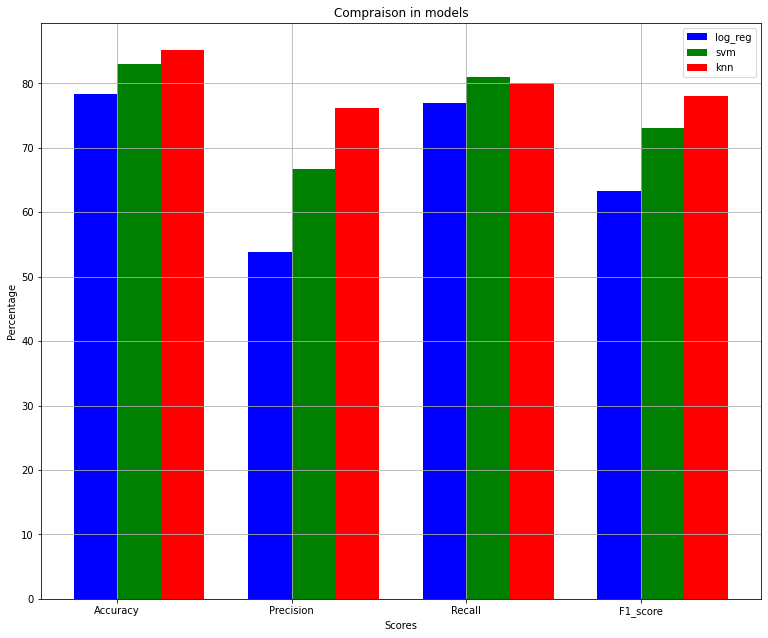

In [28]:
data=[log_scores,svm_scores,knn_scores]
X = np.arange(4)
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0,0,1,1])
ax.grid(True)
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25,label="log_reg")
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25,label="svm")
ax.bar(X + 0.50, data[2], color = 'r', width = 0.25,label="knn")
ax.set_xlabel('Scores')
ax.set_ylabel('Percentage')
ax.set_title('Compraison in models')
ax.set_xticks(X + 0.25 / 2)
ax.set_xticklabels(["Accuracy","Precision","Recall","F1_score"])
ax.legend()

## Hyper-Parameter Tuning

In [29]:
from sklearn.model_selection import GridSearchCV
 
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid.fit(X_train,Y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.802 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.793 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.818 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.719 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.767 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.653 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.653 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.653 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.653 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.650 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.653 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [30]:
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 100, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=100, gamma=1)


In [31]:

grid_predictions = grid.predict(X_test)

In [32]:
print(confusion_matrix(grid_predictions,Y_test))

[[87 10]
 [ 9 45]]


In [33]:
print("Confusion Matrix:\n",confusion_matrix(grid_predictions,Y_test))
print("Accuracy Score: ",accuracy_score(grid_predictions,Y_test))
print("Precision  Score: ",precision_score(grid_predictions,Y_test))
print("Recall Score: ",recall_score(grid_predictions,Y_test))
print("F1 Score: ",f1_score(grid_predictions,Y_test))

Confusion Matrix:
 [[87 10]
 [ 9 45]]
Accuracy Score:  0.8741721854304636
Precision  Score:  0.8181818181818182
Recall Score:  0.8333333333333334
F1 Score:  0.8256880733944955


In [34]:
filename="diabetes.pkl"
pickle.dump(grid,open(filename,'wb'))